In [1]:
#import library
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
import math

import seaborn as sns
import pandas as pd
%matplotlib inline

<b> Plot the true banana-shape distribution

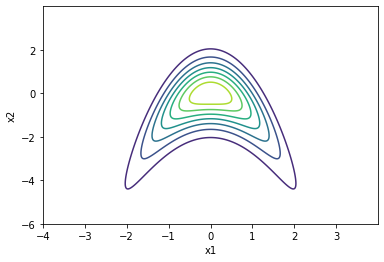

In [2]:
from scipy.stats import multivariate_normal

def plot_true():
    x, y = np.mgrid[-4:4:.01, -6:4:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = x**2+y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    plt.contour(x, y, rv.pdf(pos))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_true()

In [70]:
## initial the model
mu= [0.,0.]


cov = [[ 10,  0.],
        [ 0.,  10]]

c = 0 # mean of observations
N = 10 # number of observation data
sigma2y = 10 # standard deviation of observation data
## generate the observation data
# y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
# D = tf.convert_to_tensor(y_,dtype = tf.float32)

y_1 = np.random.normal(loc =0, scale = sigma2y, size = N)
y_2 = np.random.normal(loc =0, scale = sigma2y, size = N)
D1 = tf.convert_to_tensor(y_1,dtype = tf.float32)
D2 = tf.convert_to_tensor(y_2,dtype = tf.float32)

## define the log probability
def joint_log_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    
    y = tfd.MultivariateNormalFullCovariance(
            loc = [theta1,theta2],
            covariance_matrix= cov)
    z2 = tf.stack([D1, D2], axis=-1)
#     y = tfd.Normal(loc = tf.add(theta2,theta1), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(tf.squeeze(z2))))


<b> Random walk Matropolis Hasting MCMC to explore the banana-shape distribution

In [71]:

num_results = 5000
burnin = 500

initial_chain_state = [
    0. * tf.ones([], dtype=tf.float32, name="init_t1"),
    0. * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(y_, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)
samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 53.7%


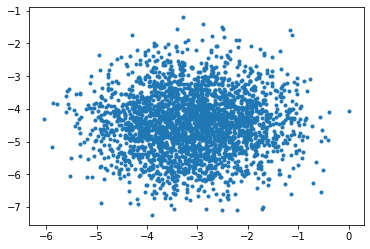

In [72]:
##plot the result
x_accepted = []
y_accepted =[]
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
        
# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(x_accepted,y_accepted,'.')

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))

In [60]:
mu = tf.constant([10., 10.])
for i in range(100):
    with tf.GradientTape() as t:  
        t.watch(mu)
        theta1 = mu[0]
        theta2 = mu[1]
        loss = tf.negative(joint_log_prob(D,theta1,theta2))
        dlossdmu = t.gradient(loss,mu)
        print(mu.numpy(),dlossdmu.numpy())
        mu = mu - 0.01*dlossdmu
        


[10. 10.] [815.2296  804.13824]
[1.8477039 1.9586182] [8.7261200e-05 5.7935715e-05]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07]
[1.8477031 1.9586176] [ 5.2452087e-06 -4.7683716e-07

<b> HMC <b>

In [215]:
num_results = 5000
burnin = 500

initial_chain_state = [
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(y_, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size = 0.01,
        num_leapfrog_steps = 5),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 98.6%


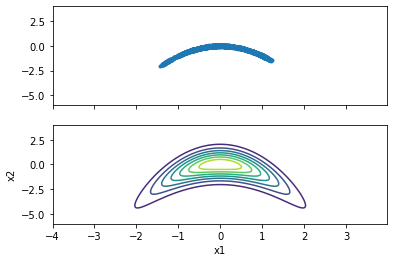

In [216]:

for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
ax1.plot(x_accepted,y_accepted,'.')
plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))


Sample from Prior

In [ ]:

num_results = 1000
burnin = 0

initial_chain_state = [
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)
samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

In [ ]:
##plot the result
x_accepted = []
y_accepted =[]
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
        
f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
ax1.plot(x_accepted,y_accepted,'.')
plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))

Define the prior by multuvatiate distribution

In [131]:
mu= [0.,0.]


cov = [[ 1,  0.],
        [ 0.,  1]]


In [134]:
## initial the model

c = 0 # mean of observations
N = 1000 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

## define the log probability
def joint_log_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D)))

In [135]:

num_results = 5000
burnin = 500

initial_chain_state = [
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(y_, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size = 0.01,
        num_leapfrog_steps = 5),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 97.5%


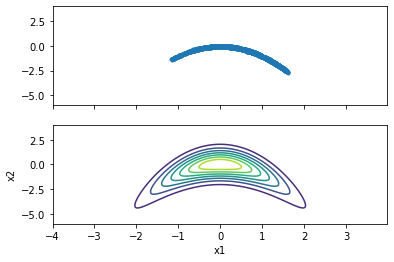

In [136]:
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
ax1.plot(x_accepted,y_accepted,'.')
plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))


<b> Hessian MCMC - banana v0.0

In [289]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

mean = [0.,0.]


def joint_log_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mean,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D)))


In [290]:
joint_log_prob(D,-0.,0.)

<tf.Tensor: id=186238487, shape=(), dtype=float32, numpy=-143.59192>

<b> Gradient Descent

In [291]:
mu = tf.constant([-4., -1.])
for i in range(1000):
    with tf.GradientTape() as t:  
        t.watch(mu)
        theta1 = mu[0]
        theta2 = mu[1]
        loss = tf.negative(joint_log_prob(D,theta1,theta2))
        dlossdmu = t.gradient(loss,mu)
        print(mu.numpy(),dlossdmu.numpy())
        mu = mu - 0.1*dlossdmu
        


[-4. -1.] [-11934.837    1490.3546]
[1189.4838  -150.03546] [3.3655767e+11 1.4147202e+08]
[-3.3655765e+10 -1.4147352e+07] [-7.6244486e+33  1.1327106e+23]
[ 7.6244487e+32 -1.1327106e+22] [inf inf]
[-inf -inf] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[n

[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]


[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]
[nan nan] [nan nan]


In [253]:
MAP = mu
MAP

<tf.Tensor: id=186023349, shape=(2,), dtype=float32, numpy=array([-0.00116406,  0.11700825], dtype=float32)>

In [257]:
def compute_hessian(fn, vars):
    mat = []
    for v2 in vars:
        for i in range(np.shape(vars)[0]):
            jac =[]
            with tf.GradientTape() as t2:
                for v1 in vars:
                    with tf.GradientTape() as t:
                        f = fn(vars)
                        jac.append(t.gradient(f,v1))
                hess = t2.gradient(jac[i],v2)
                if type(hess) == type(None):
                    mat.append(0)
                else:mat.append(hess.numpy())
    return np.reshape(mat,[np.shape(vars)[0],np.shape(vars)[0]])



In [330]:
MAP = [-1.,1.]

In [331]:
def f(vars):
    return (-joint_log_prob(D,vars[0],vars[1]))

theta1 = tf.Variable(MAP[0])
theta2 = tf.Variable(MAP[1])

hess = compute_hessian(f,[theta2,theta2])

hess


array([[2., 2.],
       [2., 2.]], dtype=float32)

In [303]:
def f(vars):
    return(vars[0]**3+2*vars[1]**2)

In [307]:
MAP = [10.,2.]

theta1 = tf.Variable(MAP[0])
theta2 = tf.Variable(MAP[1])
hess = compute_hessian(f,[theta1,theta2])
hess

array([[60.,  0.],
       [ 0.,  4.]])